<a href="https://colab.research.google.com/github/steve859/traffic_flow_prediction/blob/sensor_dataset_Duy/model/notebooks/01_pretrain_STGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
if os.path.exists("/content/traffic_flow_prediction"):
    !rm -rf /content/traffic_flow_prediction

!git clone https://github.com/steve859/traffic_flow_prediction.git
%cd traffic_flow_prediction
!git checkout sensor_dataset_Duy
# Setup dataset paths
METR_H5 = "/content/drive/MyDrive/Project Data/Dataset/metr-la.h5"
ADJ_PKL = "/content/drive/MyDrive/Project Data/Dataset/adj_mx.pkl"

print("SETUP DONE")


Mounted at /content/drive
Cloning into 'traffic_flow_prediction'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 77 (delta 27), reused 31 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (77/77), 2.29 MiB | 7.46 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/traffic_flow_prediction
Branch 'sensor_dataset_Duy' set up to track remote branch 'sensor_dataset_Duy' from 'origin'.
Switched to a new branch 'sensor_dataset_Duy'
SETUP DONE


In [2]:
import os, h5py, numpy as np, pprint

METR_H5 = "/content/drive/MyDrive/Project Data/Dataset/metr-la.h5"

print("Check file exists:", os.path.exists(METR_H5), METR_H5)
if not os.path.exists(METR_H5):
    raise FileNotFoundError(f"File not found: {METR_H5}. Kiểm tra đường dẫn trong Drive.")

# Helper: recursively list HDF5 content
def print_h5_tree(f):
    def visitor(name, obj):
        try:
            typ = 'Group' if isinstance(obj, h5py.Group) else 'Dataset'
            shape = getattr(obj, 'shape', None)
            dtype = getattr(obj, 'dtype', None)
            print(f"{name}  |  {typ}  |  shape={shape}  |  dtype={dtype}")
        except Exception as e:
            print(f"{name}  |  <error getting info: {e}>")
    f.visititems(visitor)

with h5py.File(METR_H5, 'r') as f:
    print("HDF5 file keys / tree:")
    print_h5_tree(f)
    # gather candidate datasets (numeric arrays)
    candidates = []
    def collect(name, obj):
        if isinstance(obj, h5py.Dataset):
            shape = getattr(obj, 'shape', ())
            if len(shape) >= 2:  # likely time x nodes
                candidates.append((name, shape, obj.dtype))
    f.visititems(collect)

    if not candidates:
        print("\nKhông tìm thấy dataset 2D trong file. In root keys:")
        pprint.pprint(list(f.keys()))
    else:
        print("\nCandidate numeric datasets (name, shape, dtype):")
        pprint.pprint(candidates)

        # Heuristic: prefer dataset named 'speed' or with shape[1] between 100..500 (METR has 207 nodes)
        chosen = None
        for name, shape, dtype in candidates:
            lower_name = name.lower()
            if 'speed' in lower_name or 'data' in lower_name or 'traffic' in lower_name:
                chosen = name
                break
        if chosen is None:
            # pick dataset with second-dim between 100 and 500 if possible
            for name, shape, dtype in candidates:
                if len(shape) >= 2 and 100 <= shape[1] <= 500:
                    chosen = name
                    break
        if chosen is None:
            # fallback to first candidate
            chosen = candidates[0][0]

        print(f"\n--> Loading dataset: {chosen}")
        data = f[chosen][:]
        print("Loaded data shape:", data.shape, "dtype:", data.dtype)



Check file exists: True /content/drive/MyDrive/Project Data/Dataset/metr-la.h5
HDF5 file keys / tree:
df  |  Group  |  shape=None  |  dtype=None
df/axis0  |  Dataset  |  shape=(207,)  |  dtype=|S6
df/axis1  |  Dataset  |  shape=(34272,)  |  dtype=int64
df/block0_items  |  Dataset  |  shape=(207,)  |  dtype=|S6
df/block0_values  |  Dataset  |  shape=(34272, 207)  |  dtype=float64

Candidate numeric datasets (name, shape, dtype):
[('df/block0_values', (34272, 207), dtype('<f8'))]

--> Loading dataset: df/block0_values
Loaded data shape: (34272, 207) dtype: float64


In [3]:
data = data.astype(np.float32)
print("Final data shape:", data.shape)
print("Min:", data.min(), "Max:", data.max())


Final data shape: (34272, 207)
Min: 0.0 Max: 70.0


Tạo Sliding Window (Pretrain METR-LA)

In [4]:
# ===== Sliding window config =====
INPUT_LEN = 12    # 12 x 5 phút = 60
OUTPUT_LEN = 12   # dự báo 60 phút tương lai

def create_sliding_window(data, input_len, output_len):
    X, y = [], []
    T = data.shape[0]

    for t in range(T - input_len - output_len):
        X.append(data[t:t + input_len])
        y.append(data[t + input_len:t + input_len + output_len])

    return np.array(X), np.array(y)

# ===== Create dataset =====
X, y = create_sliding_window(data, INPUT_LEN, OUTPUT_LEN)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (34248, 12, 207)
y shape: (34248, 12, 207)


Chia train / val / test

In [5]:
# ===== Split ratio =====
train_ratio = 0.7
val_ratio   = 0.1

n_samples = X.shape[0]

train_size = int(n_samples * train_ratio)
val_size   = int(n_samples * val_ratio)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (23973, 12, 207) (23973, 12, 207)
Val:   (3424, 12, 207) (3424, 12, 207)
Test:  (6851, 12, 207) (6851, 12, 207)


Add feature dimension

In [6]:
# ===== Add feature dimension =====
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print("X_train:", X_train.shape)
print("X_val:  ", X_val.shape)
print("X_test: ", X_test.shape)


X_train: (23973, 12, 207, 1)
X_val:   (3424, 12, 207, 1)
X_test:  (6851, 12, 207, 1)


Convert to PyTorch

In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Convert to torch tensor
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

print("X_train_t:", X_train_t.shape)
print("y_train_t:", y_train_t.shape)


Using device: cuda
X_train_t: torch.Size([23973, 12, 207, 1])
y_train_t: torch.Size([23973, 12, 207])


Reshape + Define LSTM + Train

In [8]:
import torch.nn as nn
import torch.optim as optim

# ===== Reshape for LSTM =====
X_train_lstm = X_train_t.squeeze(-1)
X_val_lstm   = X_val_t.squeeze(-1)

# ===== LSTM Model =====
class LSTMForecast(nn.Module):
    def __init__(self, num_nodes, hidden_size=64, output_len=12):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_nodes,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, num_nodes * output_len)
        self.output_len = output_len
        self.num_nodes = num_nodes

    def forward(self, x):
        out, _ = self.lstm(x)              # (B, T, H)
        out = out[:, -1, :]                # last timestep
        out = self.fc(out)                 # (B, output_len * nodes)
        out = out.view(-1, self.output_len, self.num_nodes)
        return out

num_nodes = X_train_lstm.shape[2]
model = LSTMForecast(num_nodes).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ===== Train loop =====
EPOCHS = 10
BATCH_SIZE = 64

for epoch in range(EPOCHS):
    model.train()
    perm = torch.randperm(X_train_lstm.size(0))

    total_loss = 0
    for i in range(0, X_train_lstm.size(0), BATCH_SIZE):
        idx = perm[i:i+BATCH_SIZE]
        xb = X_train_lstm[idx]
        yb = y_train_t[idx]

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {total_loss:.4f}")


Epoch 1/10 | Train Loss: 955267.9396
Epoch 2/10 | Train Loss: 516252.1732
Epoch 3/10 | Train Loss: 274226.3700
Epoch 4/10 | Train Loss: 155366.1475
Epoch 5/10 | Train Loss: 105239.1546
Epoch 6/10 | Train Loss: 88076.0256
Epoch 7/10 | Train Loss: 83072.0574
Epoch 8/10 | Train Loss: 80508.1734
Epoch 9/10 | Train Loss: 79547.9623
Epoch 10/10 | Train Loss: 78913.8578


Save checkpoint

In [9]:
torch.save(
    model.state_dict(),
    "/content/traffic_flow_prediction/model/lstm_pretrain_metrla.pt"
)
print("Checkpoint saved successfully")


Checkpoint saved successfully


In [10]:
# ===== Load checkpoint & switch to evaluation mode =====
model.load_state_dict(
    torch.load(
        "/content/traffic_flow_prediction/model/lstm_pretrain_metrla.pt",
        map_location=device
    )
)

model.eval()
print("Checkpoint loaded. Model set to eval mode.")


Checkpoint loaded. Model set to eval mode.


Inference trên validation set

In [11]:
# ===== Inference (Validation) =====
with torch.no_grad():
    y_pred = model(X_val_lstm.to(device))
    y_true = y_val_t.to(device)

print("Inference done.")
print("y_pred shape:", y_pred.shape)
print("y_true shape:", y_true.shape)


Inference done.
y_pred shape: torch.Size([3424, 12, 207])
y_true shape: torch.Size([3424, 12, 207])


Chuyển sang numpy + inverse scaling

In [12]:
# ===== To numpy & inverse scaling (if scaler exists) =====
y_pred_np = y_pred.detach().cpu().numpy()
y_true_np = y_true.detach().cpu().numpy()

# Nếu bạn CÓ dùng scaler khi train thì bật block này
try:
    y_pred_np = scaler.inverse_transform(
        y_pred_np.reshape(-1, y_pred_np.shape[-1])
    ).reshape(y_pred_np.shape)

    y_true_np = scaler.inverse_transform(
        y_true_np.reshape(-1, y_true_np.shape[-1])
    ).reshape(y_true_np.shape)

    print("Inverse scaling applied.")
except NameError:
    print("No scaler found. Skipped inverse scaling.")

print("y_pred_np:", y_pred_np.shape)
print("y_true_np:", y_true_np.shape)


No scaler found. Skipped inverse scaling.
y_pred_np: (3424, 12, 207)
y_true_np: (3424, 12, 207)


Tính metrics (MAE, RMSE, MAPE, Pearson)

In [14]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true_flat = y_true_np.reshape(-1)
y_pred_flat = y_pred_np.reshape(-1)

mae = mean_absolute_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-5))) * 100
pearson = np.corrcoef(y_true_flat, y_pred_flat)[0, 1]

print(f"MAE    : {mae:.4f}")
print(f"RMSE   : {rmse:.4f}")
print(f"MAPE % : {mape:.2f}")
print(f"Pearson: {pearson:.4f}")


MAE    : 9.6375
RMSE   : 15.0299
MAPE % : 17599828.00
Pearson: 0.6449


 Visualization : Vẽ Real vs Predicted + Residual

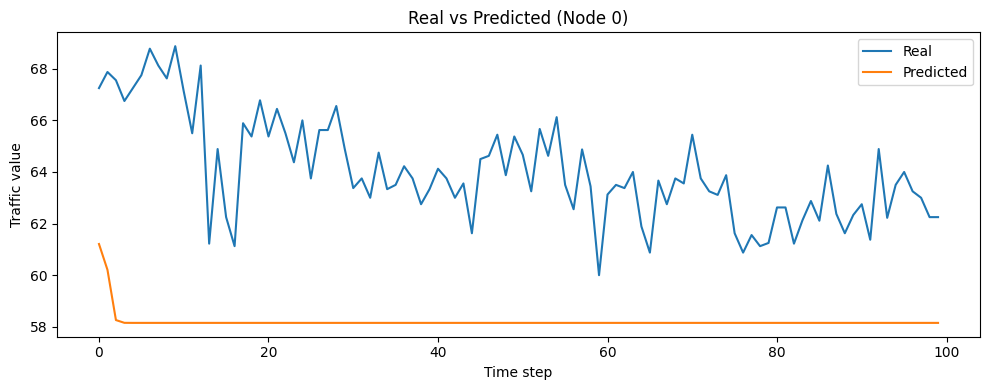

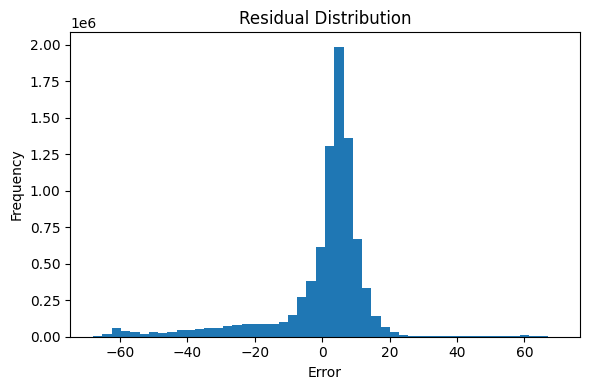

In [15]:
# ===== Visualization =====
import matplotlib.pyplot as plt

# chọn 1 node (sensor) đại diện
node_id = 0
time_len = 100  # số timestep hiển thị

# --- Real vs Predicted ---
plt.figure(figsize=(10,4))
plt.plot(y_true_np[:time_len, 0, node_id], label="Real")
plt.plot(y_pred_np[:time_len, 0, node_id], label="Predicted")
plt.title(f"Real vs Predicted (Node {node_id})")
plt.xlabel("Time step")
plt.ylabel("Traffic value")
plt.legend()
plt.tight_layout()
plt.show()

# --- Residual Distribution ---
residual = y_true_np - y_pred_np
plt.figure(figsize=(6,4))
plt.hist(residual.flatten(), bins=50)
plt.title("Residual Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
